In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
import logging
import torch
import torch.nn as nn
import seaborn as sns
import time

from ili.embedding import FCN
from sklearn.model_selection import train_test_split
import scipy
from ili.utils.ndes_pt import LampeEnsemble

from funcs import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)



Device: cpu


In [2]:
wst_train = np.load('/anvil/scratch/x-abairagi/cmass-ili/quijotelike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0+zwst/kmax-0.4/x_train.npy').astype(np.float32)
wst_test = np.load('/anvil/scratch/x-abairagi/cmass-ili/quijotelike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0+zwst/kmax-0.4/x_test.npy').astype(np.float32)
params_train = np.load('/anvil/scratch/x-abairagi/cmass-ili/quijotelike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0+zwst/kmax-0.4/theta_train.npy').astype(np.float32)
params_test =np.load('/anvil/scratch/x-abairagi/cmass-ili/quijotelike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0+zwst/kmax-0.4/theta_test.npy').astype(np.float32)

FileNotFoundError: [Errno 2] No such file or directory: '/anvil/scratch/x-abairagi/cmass-ili/quijotelike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0+zwst/kmax-0.4/x_train.npy'

In [2]:
dir_path='/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/'
train_x, train_theta = np.load(dir_path+'x_train.npy'), np.load(dir_path+'theta_train.npy')
val_x, val_theta = np.load(dir_path+'x_val.npy'), np.load(dir_path+'theta_val.npy')
test_x, test_theta = np.load(dir_path+'x_test.npy'), np.load(dir_path+'theta_test.npy')

nbody_path = "/anvil/scratch/x-abairagi/cmass-ili/abacus/nbody/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/"
test_nbody_x, test_nbody_theta = np.load(nbody_path+'x_test.npy'), np.load(nbody_path+'theta_test.npy')

In [6]:
test_x=normalize(train_x, test_x)
test_nbody_x=normalize(train_x, test_nbody_x)

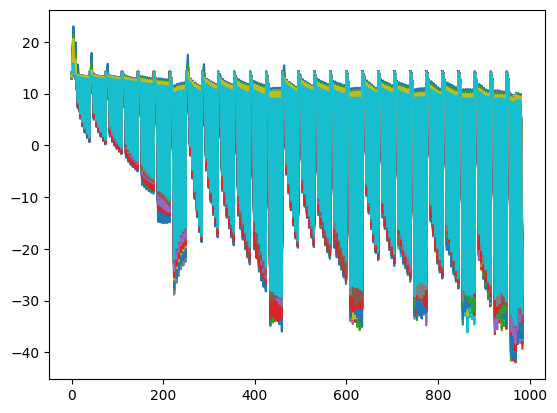

In [14]:
plt.plot(wst_test.T);

In [68]:
import glob
# glob.glob('/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0+zwst/kmax-0.4/nets/*')

In [3]:
logprobs = []
c = 0
for i in range(100):
    try:
        model = torch.load(f'/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/nets/posterior_{i}.pth')
        # model = torch.load(f'/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/nets/net-{i}/posterior.pkl')
        model.eval()
        logprob = evaluate_posterior(model, torch.tensor(test_x).float().to(device), torch.tensor(test_theta).float().to(device))
        # print(i, logprob)
        logprobs.append(logprob)

    except Exception as e:
        print(i, e)
        logprobs.append(-np.inf)

logprobs = np.array(logprobs)

0 [Errno 2] No such file or directory: '/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/nets/posterior_0.pth'
1 [Errno 2] No such file or directory: '/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/nets/posterior_1.pth'
2 [Errno 2] No such file or directory: '/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/nets/posterior_2.pth'
3 [Errno 2] No such file or directory: '/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/nets/posterior_3.pth'
4 [Errno 2] No such file or directory: '/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/nets/posterior_4.pth'
5 [Errno 2] No such file or directory: '/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/nets/posterior_5.pth'
6 [Errno 2] No such file or directory: '/anvil/scratch/x-a

In [10]:
top_nets = np.argsort(logprobs)[::-1][:10]
logprobs[top_nets]

array([11.12647247, 10.96329689, 10.82388401, 10.66345787, 10.60794449,
       10.49635124, 10.46838284, 10.4640274 , 10.45166016, 10.35556793])

In [11]:
ensemble_list = []
for i in top_nets:
    print(f'Net {i}: {logprobs[i]}')
    model = torch.load(f'/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0+zwst/kmax-0.4/nets/posterior_{i}.pth')
    ensemble_list.append(model)

weighted = False
if weighted:
    ensemble_logprobs = logprobs[top_nets]
    weights = scipy.special.softmax(ensemble_logprobs)
    weights = torch.Tensor(weights)
else:
    weights = torch.ones(len(top_nets)) / len(top_nets)

ensemble = LampeEnsemble(
    posteriors=ensemble_list,
    weights=weights  # equally weighted
)

Net 97: 11.126472473144531
Net 20: 10.963296890258789
Net 60: 10.823884010314941
Net 36: 10.663457870483398
Net 93: 10.60794448852539
Net 99: 10.49635124206543
Net 54: 10.468382835388184
Net 88: 10.464027404785156
Net 37: 10.45166015625
Net 11: 10.355567932128906


In [12]:
torch.save(ensemble, '/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0+zwst/kmax-0.4/nets/posterior_top10.pth')

In [33]:
ensemble = torch.load(dir_path+'nets/posterior_top10.pth')
# ensemble.eval()
# evaluate_posterior(ensemble, torch.tensor(wst_test).float().to(device), torch.tensor(params_test).float().to(device))

In [23]:
target_prior = ili.utils.Uniform(low=np.ones(5)*(-1000), high=np.ones(5)*1000, device=device)

for i in range(10):
    ensemble.posteriors[i].prior = target_prior
ensemble.prior=target_prior


In [8]:
ind = 68
# np.random.randint(0, len(params_test))
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
)
fig = metric(
    posterior=ensemble,
    x_obs = test_nbody_x[ind], theta_fid=test_nbody_theta[ind]
)

NameError: name 'PlotSinglePosterior' is not defined

In [15]:
ps_matt=np.load("/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/posterior_samples.npy")
matt_id=np.load("/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/ids_test.npy")
matt_test_x=np.load("/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/x_test.npy")
matt_test_theta=np.load("/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/theta_test.npy")

In [43]:
# samples.shape
# np.save(nbody_path+"posterior_samples.npy",samples)

In [7]:
# num_samples=1000
# samples = np.array([]).reshape(num_samples,0,5)
# for data in test_nbody_x[4:]:
#     samples=np.concatenate([samples,generate_sample(ensemble,data,num_samples,device).reshape(num_samples,1,5)],axis=1)


In [ ]:
samples=generate_sample(ensemble, test_x[68], 1000, device)

In [127]:
theta, test_theta[166]

(array([0.2585 , 0.06241, 0.6663 , 0.9619 , 0.8699 ]),
 array([0.2585 , 0.06241, 0.6663 , 0.9619 , 0.8699 ]))

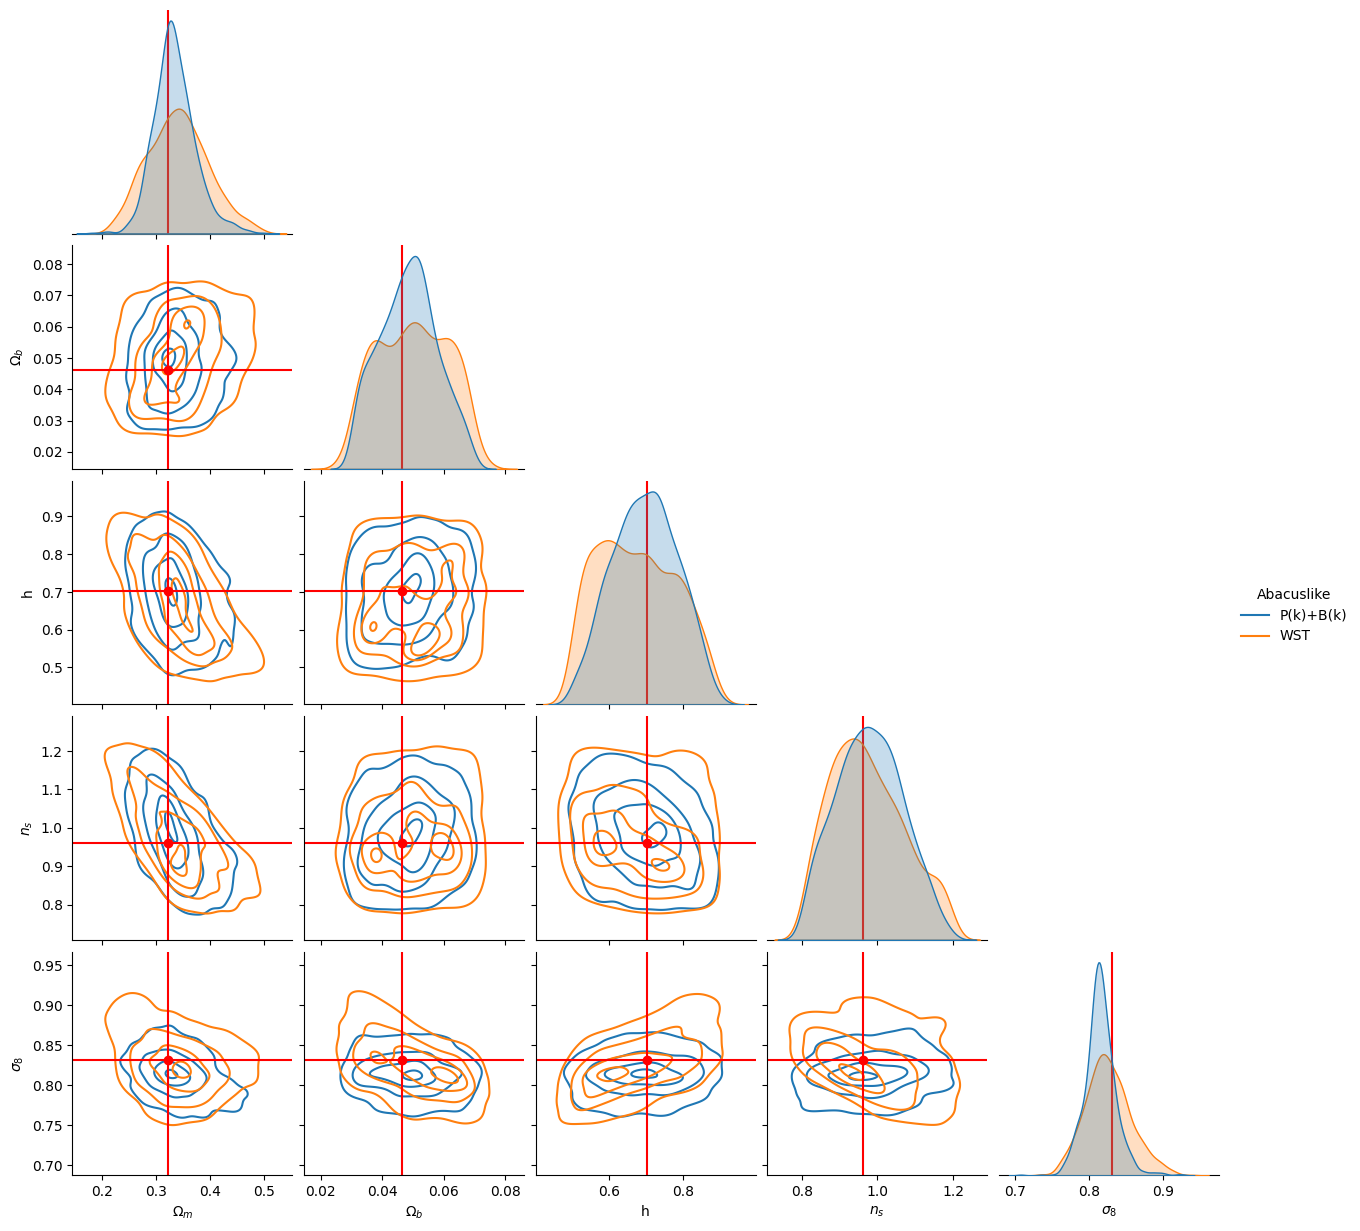

In [17]:
nbody="Abacuslike"
ind=68
df_matt=pd.DataFrame(ps_matt[:,ind], columns=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"])
df_ab=pd.DataFrame(samples, columns=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"])
df_matt[nbody]="P(k)+B(k)"
df_ab[nbody]="WST"
df = pd.concat([df_matt, df_ab])
theta = matt_test_theta[ind]
fig=sns.pairplot(df, kind="kde", corner=True, hue=nbody, plot_kws=dict(common_norm=False, levels=[0.05, 0.32, 0.68, 0.95]))
    
for i in range(5):
    for j in range(i + 1):
        if i == j:
            fig.axes[i, i].axvline(theta[i], color="r")
        else:
            fig.axes[i, j].axhline(theta[i], color="r")
            fig.axes[i, j].axvline(theta[j], color="r")
            fig.axes[i, j].plot(theta[j], theta[i], "ro")
            

100%|██████████| 197/197 [01:27<00:00,  2.26it/s]
INFO:root:Mean logprob: 1.2289e+01Median logprob: 1.2465e+01
100%|██████████| 100/100 [00:01<00:00, 52.54it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


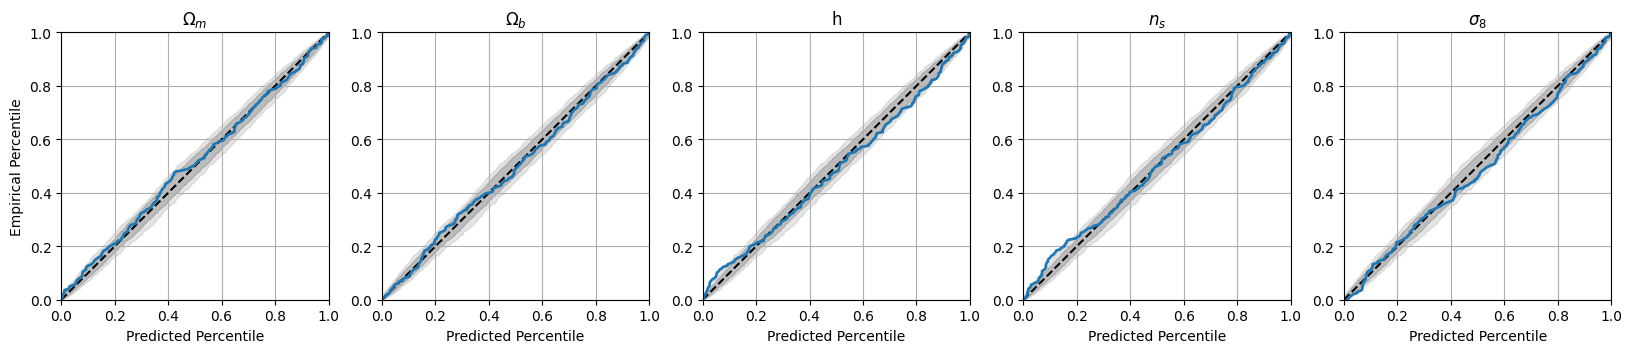

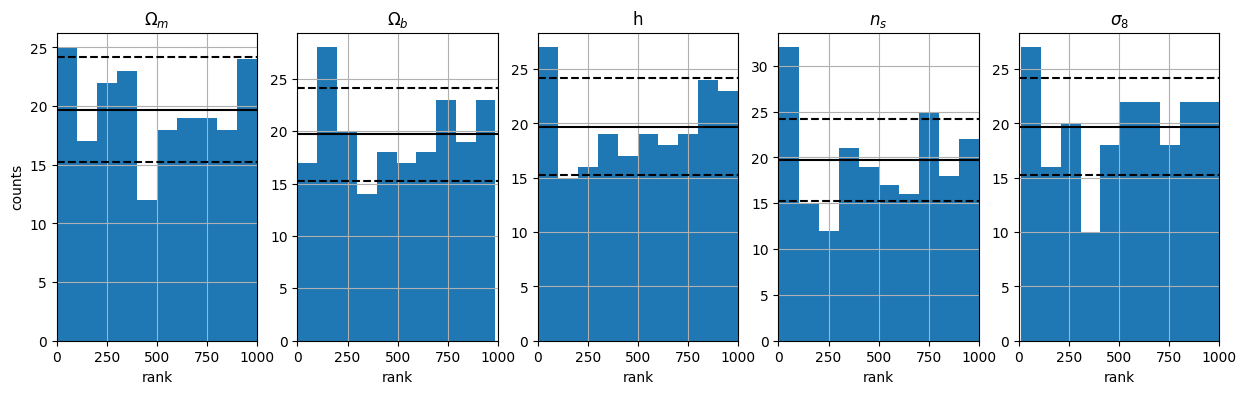

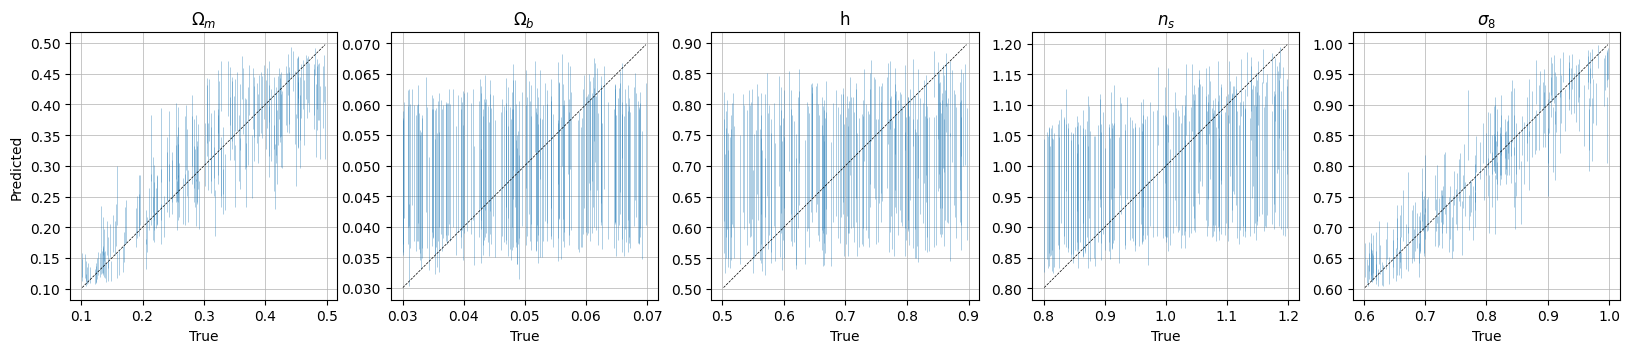

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


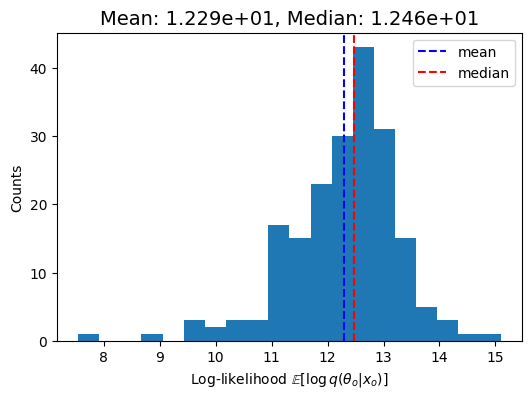

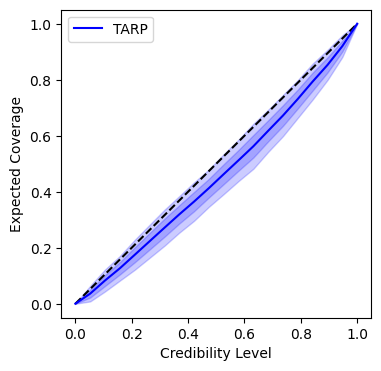

In [18]:
metric = PosteriorCoverage(num_samples=1000, 
    sample_method='direct', labels=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"])

fig = metric(
    posterior=ensemble,
#     .posteriors[0],
    x=test_x, theta=test_theta
)

In [37]:
metric = PosteriorCoverage(num_samples=1000, 
    sample_method='direct', labels=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"])

fig = metric(
    posterior=ensemble,
#     .posteriors[0],
    x=test_nbody_x, theta=test_nbody_theta
)
# [[0,1,2,4,5,6,7,9,10,11]]



  0%|          | 0/19 [00:00<?, ?it/s]

  5%|▌         | 1/19 [00:00<00:06,  2.80it/s]

 11%|█         | 2/19 [00:00<00:07,  2.27it/s]

 16%|█▌        | 3/19 [01:20<07:10, 26.88s/it]


KeyboardInterrupt: 

In [ ]:
sa